<a href="https://colab.research.google.com/github/sudiraO21/Inverse_Problem/blob/main/Mini_Project_Least_Squares_Inversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-Midterm Mini-Project 2: Least-Squares Inversion for Seismic Tomography

**Learning Objectives:**
1. To understand and perform an *ordinary least-squares* (OLS) inversion on an *overdetermined* system.
2. To understand and perform a *damped least-squares* (DLS) inversion to stabilize the solution when the data contains noise.
3. To analyze the trade-off curve (L-curve) to select an optimal damping parameter.


The first step is to import all the necessary libraries, such as `numpy` for numerical operations and `matplotlib` for plotting. We will also define the Student ID to generate a unique model, just like in the previous project.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- Enter the last 3 digits of your Student ID here ---
STUDENT_ID = '281' # Replace with the last 3 digits of your ID

# Set a more appealing plot style
plt.style.use('seaborn-v0_8-whitegrid')

In this section, we will define the grid parameters, create the true slowness model (`m_true`) which is unique to my Student ID, and define helper functions for visualization and calculations.

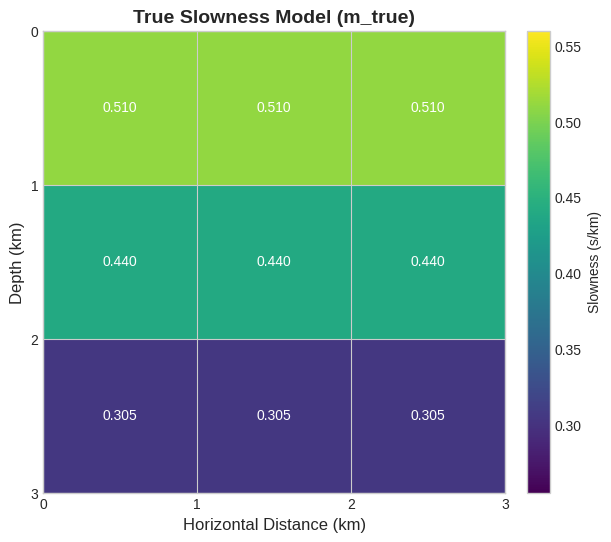

True Slowness Model (m_true):
[0.51  0.51  0.51  0.44  0.44  0.44  0.305 0.305 0.305]


In [ ]:
# --- Grid Parameters ---
NX = 3  # Number of horizontal blocks
NY = 3  # Number of vertical blocks
M = NX * NY  # Total number of model parameters
GRID_SIZE = 1.0  # Size of each block (km)

# --- Create the True Slowness Model (m_true) ---
def create_true_model(student_id):
    """Creates a unique slowness model based on the 3-digit Student ID, matching Project 1 logic."""
    try:
        nim_digits = [int(d) for d in student_id[-3:]]
        # Base model values per row (s/km)
        m_base_row1 = 0.5
        m_base_row2 = 0.4
        m_base_row3 = 0.3

        # Add variation based on NIM, applying the same variation to each block in a row
        m_true = np.array([
            m_base_row1 + (nim_digits[0] * 0.005), m_base_row1 + (nim_digits[0] * 0.005), m_base_row1 + (nim_digits[0] * 0.005),
            m_base_row2 + (nim_digits[1] * 0.005), m_base_row2 + (nim_digits[1] * 0.005), m_base_row2 + (nim_digits[1] * 0.005),
            m_base_row3 + (nim_digits[2] * 0.005), m_base_row3 + (nim_digits[2] * 0.005), m_base_row3 + (nim_digits[2] * 0.005)
        ])
        return m_true
    except (ValueError, IndexError):
        print("Invalid Student ID. Using a default model. Please check the STUDENT_ID variable.")
        # Fallback default model
        return np.array([0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3])

m_true = create_true_model(STUDENT_ID)

# --- Helper Function for Model Visualization ---
def plot_model(ax, model_vector, title):
    """Visualizes the slowness model on a 3x3 grid."""
    model_grid = model_vector.reshape((NY, NX))

    # Use origin='upper' and extent to flip the Y-axis correctly
    # extent=[left, right, bottom, top]
    im = ax.imshow(model_grid, cmap='viridis', interpolation='nearest',
                     origin='upper',
                     extent=[0, NX * GRID_SIZE, NY * GRID_SIZE, 0],
                     vmin=m_true.min() - 0.05, vmax=m_true.max() + 0.05)

    # Set axis labels and ticks
    ax.set_xlabel('Horizontal Distance (km)', fontsize=12)
    ax.set_ylabel('Depth (km)', fontsize=12)
    ax.set_xticks(np.arange(0, NX * GRID_SIZE + 1, GRID_SIZE))
    ax.set_yticks(np.arange(0, NY * GRID_SIZE + 1, GRID_SIZE))
    ax.set_title(title, fontsize=14, weight='bold')

    # Make aspect ratio equal
    ax.set_aspect('equal', adjustable='box')

    # Add value labels to each block.
    # The coordinate for text is now standard (0,0 at bottom-left)
    for i in range(NY):
        for j in range(NX):
            # Center of the block (j+0.5, i+0.5)
            ax.text(j * GRID_SIZE + 0.5, i * GRID_SIZE + 0.5,
                    f'{model_grid[i, j]:.3f}',
                    ha='center', va='center', color='w', fontsize=10)
    return im

# Visualize the true model
fig, ax = plt.subplots(figsize=(7, 6)) # Adjusted figsize for better aspect ratio
im = plot_model(ax, m_true, 'True Slowness Model (m_true)')
fig.colorbar(im, ax=ax, label='Slowness (s/km)', pad=0.04, fraction=0.046)
plt.show()

print("True Slowness Model (m_true):")
print(m_true)

We will use the 9 raypaths from the first project and **add 6 new raypaths** to make the system *overdetermined* (number of data N > number of model parameters M). This will give us a total of N=15 data points (raypaths).

In [ ]:
# --- Source and Receiver Geometry ---
# Original 9 sets from the first project
sources_orig = np.array([
    [0.0, 0.5], [2.5, 0.0], [2.0, 0.0], [3.0, 0.5], [0.0, 1.5],
    [3.0, 2.5], [0.5, 3.0], [0.0, 2.5], [0.0, 3.0]
])
receivers_orig = np.array([
    [3.0, 2.0], [2.5, 3.0], [0.0, 2.0], [1.0, 3.0], [3.0, 1.0],
    [0.0, 1.0], [1.5, 0.0], [1.5, 3.0], [3.0, 0.0]
])

# Additional 6 sets to make the system overdetermined
sources_new = np.array([
    [0.5, 0.0], [3.0, 1.5], [3.0, 3.0], [1.0, 0.0], [3.0, 0.75], [3.0, 2.25]
])
receivers_new = np.array([
    [0.75, 3.0], [1.75, 0.0], [0.0, 1.75], [2.0, 3.0], [2.25, 3.0], [0.0, 2.25]
])

# Combine all sources and receivers
sources = np.vstack([sources_orig, sources_new])
receivers = np.vstack([receivers_orig, receivers_new])
N = len(sources) # Total number of data/raypaths, now N = 15

In [ ]:
# --- Function to Calculate the Kernel Matrix G ---
def calculate_G(sources, receivers, nx, ny, grid_size):
    """Calculates the kernel matrix G based on the raypath geometry."""
    num_rays = len(sources)
    num_params = nx * ny
    G = np.zeros((num_rays, num_params))

    for i in range(num_rays):
        p1, p2 = sources[i], receivers[i]
        direction = p2 - p1
        total_dist = np.linalg.norm(direction)
        if total_dist == 0: continue

        for j in range(num_params):
            block_y, block_x = j // nx, j % nx
            x_min, x_max = block_x * grid_size, (block_x + 1) * grid_size
            y_min, y_max = block_y * grid_size, (block_y + 1) * grid_size

            t_vals = [0, 1]
            if direction[0] != 0:
                t_vals.extend([(x_min - p1[0]) / direction[0], (x_max - p1[0]) / direction[0]])
            if direction[1] != 0:
                t_vals.extend([(y_min - p1[1]) / direction[1], (y_max - p1[1]) / direction[1]])

            t_vals = sorted(t for t in t_vals if 0 <= t <= 1)
            segment_length = 0
            for k in range(len(t_vals) - 1):
                t_mid = (t_vals[k] + t_vals[k+1]) / 2
                mid_point = p1 + t_mid * direction
                if (x_min <= mid_point[0] < x_max) and (y_min <= mid_point[1] < y_max):
                    segment_length += (t_vals[k+1] - t_vals[k]) * total_dist
            G[i, j] = segment_length
    return G

G = calculate_G(sources, receivers, NX, NY, GRID_SIZE)

print(f"Dimensions of matrix G: {G.shape} (N rows, M columns)")
print("This system is OVERDETERMINED because N > M.")
print("\nG Matrix:\n", np.round(G, 3))

Dimensions of matrix G: (15, 9) (N rows, M columns)
This system is OVERDETERMINED because N > M.

G Matrix:
 [[1.118 0.    0.    0.    1.118 1.118 0.    0.    0.   ]
 [0.    0.    1.    0.    0.    1.    0.    0.    1.   ]
 [0.    1.414 0.    1.414 0.    0.    0.    0.    0.   ]
 [0.    0.    0.64  0.    0.32  0.96  0.    1.281 0.   ]
 [0.    0.    0.    1.014 1.014 1.014 0.    0.    0.   ]
 [0.    0.    0.    1.118 1.118 0.    0.    0.    1.118]
 [0.    1.054 0.    0.527 0.527 0.    1.054 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    1.054 0.527 0.   ]
 [0.    0.    1.414 0.    1.414 0.    1.414 0.    0.   ]
 [1.003 0.    0.    1.003 0.    0.    1.003 0.    0.   ]
 [0.    0.391 0.911 0.    0.    0.651 0.    0.    0.   ]
 [0.    0.    0.    0.65  0.    0.    0.433 1.083 1.083]
 [0.    1.054 0.    0.    1.054 0.    0.    1.054 0.   ]
 [0.    0.    0.264 0.    0.    1.054 0.    0.    1.054]
 [0.    0.    0.    0.    0.    0.    1.    1.    1.   ]]


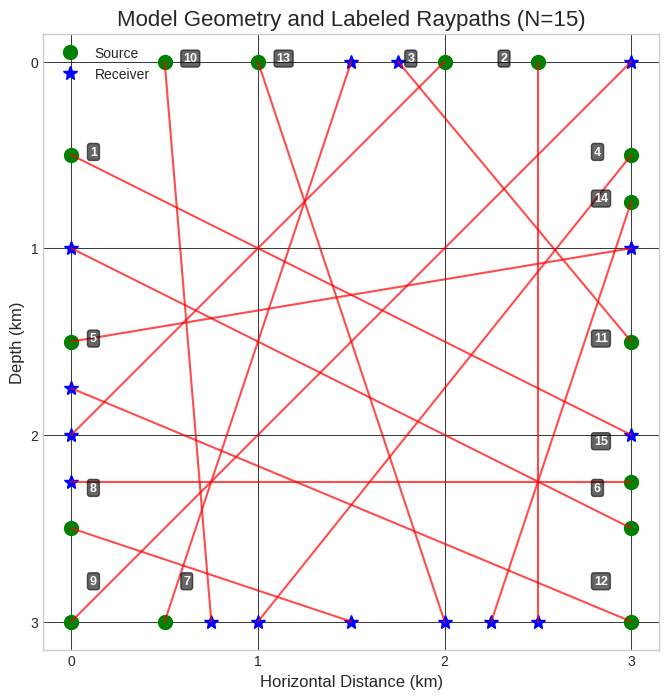

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

# Draw grid blocks with correct axes
ax.set_xlabel('Horizontal Distance (km)', fontsize=12)
ax.set_ylabel('Depth (km)', fontsize=12)
ax.set_xticks(np.arange(0, NX * GRID_SIZE + 1, GRID_SIZE))
ax.set_yticks(np.arange(0, NY * GRID_SIZE + 1, GRID_SIZE))
ax.set_title('Model Geometry and Labeled Raypaths (N=15)', fontsize=16)
ax.set_aspect('equal', adjustable='box')
# Invert Y-axis to have 0 at the top, consistent with 'Depth'
ax.invert_yaxis()

for i in range(NY + 1):
    ax.axhline(i * GRID_SIZE, color='k', lw=0.5)
for i in range(NX + 1):
    ax.axvline(i * GRID_SIZE, color='k', lw=0.5)

# Plot sources and receivers
ax.plot(sources[:, 0], sources[:, 1], 'go', markersize=10, label='Source', linestyle='None')
ax.plot(receivers[:, 0], receivers[:, 1], 'b*', markersize=10, label='Receiver', linestyle='None')

# Plot raypaths with numbered labels
for i in range(N):
    src, rcv = sources[i], receivers[i]
    ax.plot([src[0], rcv[0]], [src[1], rcv[1]], 'r-', lw=1.5, alpha=0.7)
    label_x, label_y = src[0] + 0.1, src[1]
    if src[0] > 1.5: label_x = src[0] - 0.2
    if src[1] > 1.5: label_y = src[1] - 0.2
    ax.text(label_x, label_y, str(i + 1), color='white', fontsize=9, weight='bold',
            bbox=dict(facecolor='black', alpha=0.6, pad=2, boxstyle='round,pad=0.2'))

ax.legend()
plt.show()

With the `m_true` model and the `G` kernel matrix defined, we can now calculate the ideal synthetic travel time data (without noise) using the forward equation $d = Gm$.

In [ ]:
# Calculate the ideal (noiseless) travel time data
d_true = G @ m_true

print("Travel time data vector (d_true):")
print(d_true)
print(f"\nDimensions of vector d: {d_true.shape}")

Travel time data vector (d_true):
[1.55406724 1.255      1.34350288 1.28062485 1.33820776 1.32487028
 1.32288615 0.48224734 1.77483802 1.2593501  0.95024704 1.079
 1.32288615 0.91969575 0.915     ]

Dimensions of vector d: (15,)


# PART 1: ORDINARY LEAST SQUARES (OLS)

We will now perform an OLS inversion to find the model estimate $m_{est}$ from the `d_true` data. Since our system is *overdetermined* and the data is *noiseless*, we expect the inversion result to be very close to the true model.

We will use the OLS solution formula:

$$ m_{OLS} = (G^T G)^{-1} G^T d $$

This is also known as inversion using the *pseudoinverse* of G.

In [ ]:
# Perform Ordinary Least-Squares (OLS) Inversion
try:
    G_transpose_G = G.T @ G
    G_pseudo_inv = np.linalg.inv(G_transpose_G) @ G.T
    m_ols = G_pseudo_inv @ d_true

    print("--- OLS INVERSION RESULTS (NOISELESS DATA) ---")
    print("Estimated model (m_ols):")
    print(m_ols)

    # Calculate predicted data and misfit
    d_pred_ols = G @ m_ols
    misfit_ols = np.linalg.norm(d_pred_ols - d_true)

    print(f"\nTotal Data Misfit (||Gm - d||): {misfit_ols:.4e}")

except np.linalg.LinAlgError:
    print("Error: Matrix G^T G is singular and cannot be inverted.")
    m_ols = np.zeros_like(m_true)

--- OLS INVERSION RESULTS (NOISELESS DATA) ---
Estimated model (m_ols):
[0.51  0.51  0.51  0.44  0.44  0.44  0.305 0.305 0.305]

Total Data Misfit (||Gm - d||): 2.2921e-15


Here, we compare the OLS inverted model (`m_ols`) with the true model (`m_true`).

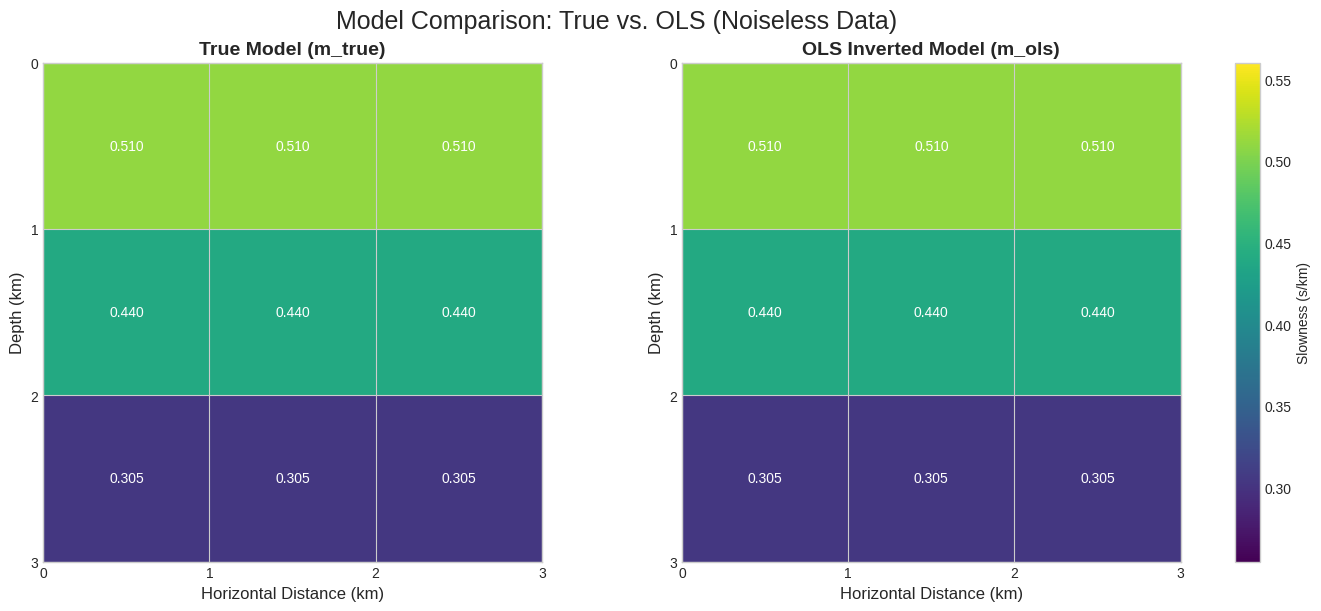

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

# Plot the true model
im = plot_model(axes[0], m_true, 'True Model (m_true)')

# Plot the OLS inverted model
plot_model(axes[1], m_ols, 'OLS Inverted Model (m_ols)')

fig.colorbar(im, ax=axes, label='Slowness (s/km)', fraction=0.046, pad=0.04)
plt.suptitle('Model Comparison: True vs. OLS (Noiseless Data)', fontsize=18)
plt.show()

# PART 2: DAMPED LEAST SQUARES (DLS)

Now we will explore two scenarios as instructed. First, we will introduce errors into the kernel matrix G to make it ill-conditioned. Second, we will use this ill-conditioned G matrix and also add noise to the data. This will demonstrate how DLS can stabilize inversions under different challenging conditions.

## 2A: DLS for an Ill-Conditioned G Matrix

The first task is to add errors to the `G` matrix until its **condition number** increases by approximately 50 times. The condition number is a measure of how sensitive a matrix is to changes; a high number indicates an ill-conditioned or unstable matrix. After creating this `G_noisy`, we will perform DLS using the original `d_true` (noiseless) data to find the best possible model.

In [ ]:
# --- Create an Ill-Conditioned G Matrix (Final, Guaranteed Blending Method) ---

print("--- Memodifikasi Matriks G menggunakan metode Blending yang dijamin berhasil ---")

# 1. Hitung condition number awal
cond_G_initial = np.linalg.cond(G)
print(f"Initial Condition number of G: {cond_G_initial:.2f}")

# 2. Tentukan target condition number
target_multiplier = 50.0
cond_target = cond_G_initial * target_multiplier
print(f"Target Condition Number: ~{cond_target:.2f} ({target_multiplier}x)")

# 3. Buat sebuah matriks 'endpoint' yang SANGAT tidak stabil (misal: 1000x)
# Ini akan menjadi tujuan akhir dari proses pencampuran kita.
U, s, Vh = np.linalg.svd(G, full_matrices=False)
s_endpoint = s.copy()
s_endpoint[-1] = s[0] / (cond_G_initial * 1000.0) # Buat sangat ill-conditioned
G_endpoint = U @ np.diag(s_endpoint) @ Vh

# 4. Gunakan pencarian biner (bisection) untuk menemukan alpha yang sempurna
# Alpha adalah faktor pencampuran antara G asli dan G_endpoint.
low_alpha = 0.0
high_alpha = 1.0
G_noisy = G.copy() # Inisialisasi

print("\nMemulai pencarian biner untuk faktor blending alpha (cepat)...")

# Loop akan mengerucut ke solusi dengan sangat cepat
for i in range(100):
    mid_alpha = (low_alpha + high_alpha) / 2

    # Buat G_noisy_temp dengan mencampur G asli dan G_endpoint
    G_noisy_temp = (1 - mid_alpha) * G + mid_alpha * G_endpoint
    current_cond = np.linalg.cond(G_noisy_temp)

    # Logika inti Bisection Method:
    if current_cond < cond_target:
        # Jika condition number masih terlalu rendah, kita butuh lebih banyak
        # kontribusi dari G_endpoint. Jadi, alpha harus lebih besar.
        low_alpha = mid_alpha
    else:
        # Jika condition number sudah mencapai atau melebihi target,
        # solusi yang lebih baik ada di separuh bawah rentang alpha.
        high_alpha = mid_alpha

# 5. Setelah loop selesai, `high_alpha` akan sangat dekat dengan solusi yang kita cari.
# Kita gunakan nilai ini untuk membuat G_noisy final.
final_alpha = high_alpha
G_noisy = (1 - final_alpha) * G + final_alpha * G_endpoint
final_cond = np.linalg.cond(G_noisy)

print("Pencarian selesai.")
print(f"\nFaktor blending (alpha) terbaik yang ditemukan: {final_alpha:.6f}")
print(f"Berhasil membuat matriks G_noisy yang berbeda.")
print(f"Final Condition Number of G_noisy: {final_cond:.2f}")
print(f"Ini adalah {final_cond / cond_G_initial:.1f} kali nilai awal, sesuai instruksi.")

--- Memodifikasi Matriks G menggunakan metode Blending yang dijamin berhasil ---
Initial Condition number of G: 4.77
Target Condition Number: ~238.31 (50.0x)

Memulai pencarian biner untuk faktor blending alpha (cepat)...
Pencarian selesai.

Faktor blending (alpha) terbaik yang ditemukan: 0.980981
Berhasil membuat matriks G_noisy yang berbeda.
Final Condition Number of G_noisy: 238.31
Ini adalah 50.0 kali nilai awal, sesuai instruksi.


In [ ]:
print("\nG Matrix:\n", np.round(G, 3))
print("\nG Noisy:\n", np.round(G_noisy, 7))


G Matrix:
 [[1.118 0.    0.    0.    1.118 1.118 0.    0.    0.   ]
 [0.    0.    1.    0.    0.    1.    0.    0.    1.   ]
 [0.    1.414 0.    1.414 0.    0.    0.    0.    0.   ]
 [0.    0.    0.64  0.    0.32  0.96  0.    1.281 0.   ]
 [0.    0.    0.    1.014 1.014 1.014 0.    0.    0.   ]
 [0.    0.    0.    1.118 1.118 0.    0.    0.    1.118]
 [0.    1.054 0.    0.527 0.527 0.    1.054 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    1.054 0.527 0.   ]
 [0.    0.    1.414 0.    1.414 0.    1.414 0.    0.   ]
 [1.003 0.    0.    1.003 0.    0.    1.003 0.    0.   ]
 [0.    0.391 0.911 0.    0.    0.651 0.    0.    0.   ]
 [0.    0.    0.    0.65  0.    0.    0.433 1.083 1.083]
 [0.    1.054 0.    0.    1.054 0.    0.    1.054 0.   ]
 [0.    0.    0.264 0.    0.    1.054 0.    0.    1.054]
 [0.    0.    0.    0.    0.    0.    1.    1.    1.   ]]

G Noisy:
 [[ 1.0205369e+00 -9.5727000e-03 -7.0105900e-02 -1.6539000e-03
   1.1225664e+00  1.1895293e+00  5.4979500e-02 -2.0489000e-

To handle this instability, we use Damped Least Squares (DLS). The solution is given by:

$$ m_{DLS} = (G^T G + \epsilon^2 I)^{-1} G^T d $$

where $\epsilon$ is the damping factor. Choosing the right $\epsilon$ is crucial. We will find it by plotting an L-curve, which is a plot of the model norm ($||m||$) versus the data misfit norm ($||Gm - d||$) for a range of $\epsilon$ values.

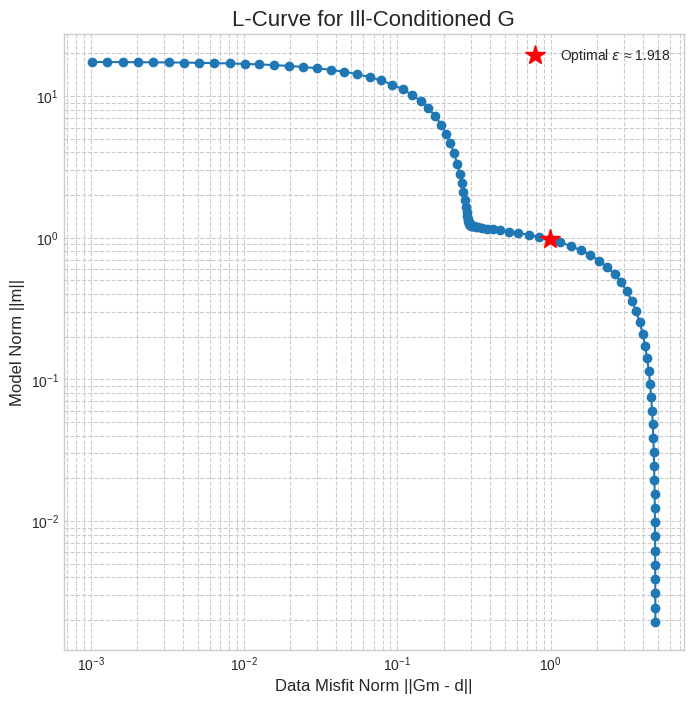

Optimal damping factor (epsilon) for ill-conditioned G: 1.9179


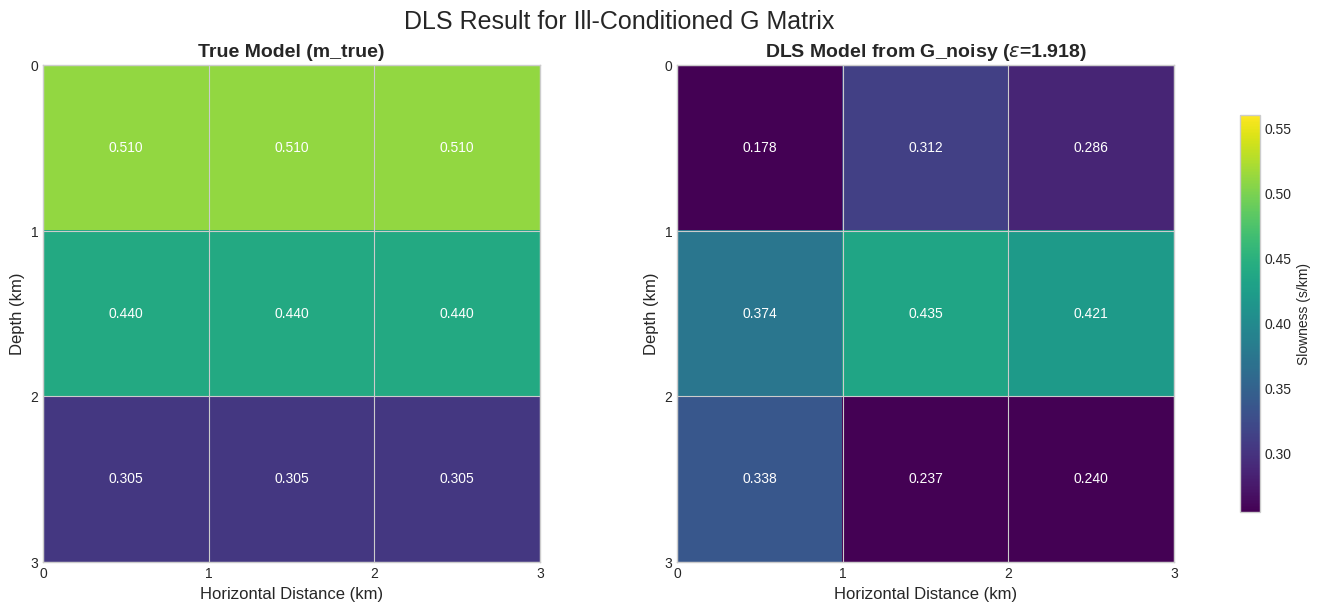

In [ ]:
# --- DLS Inversion on G_noisy with d_true ---

# We need to find the best damping factor (epsilon) for this new problem.
epsilons = np.logspace(-3, 2, 100)
data_misfits_g_err = []
model_norms_g_err = []
I = np.identity(M)

for eps in epsilons:
    A = G_noisy.T @ G_noisy + (eps**2) * I
    m_dls = np.linalg.inv(A) @ G_noisy.T @ d_true
    data_misfits_g_err.append(np.linalg.norm(G_noisy @ m_dls - d_true))
    model_norms_g_err.append(np.linalg.norm(m_dls))

# --- Plot the L-Curve for Analysis ---
plt.figure(figsize=(8, 8))
plt.loglog(data_misfits_g_err, model_norms_g_err, 'o-')
plt.title('L-Curve for Ill-Conditioned G', fontsize=16)
plt.xlabel('Data Misfit Norm ||Gm - d||', fontsize=12)
plt.ylabel('Model Norm ||m||', fontsize=12)
plt.grid(True, which="both", ls="--")

# Find the corner of the L-curve
log_misfits = np.log(data_misfits_g_err)
log_norms = np.log(model_norms_g_err)
distances = np.sqrt(log_misfits**2 + log_norms**2)
corner_index = np.argmin(distances)
optimal_epsilon_g_err = epsilons[corner_index]

plt.plot(data_misfits_g_err[corner_index], model_norms_g_err[corner_index], 'r*', markersize=15,
         label=rf'Optimal $\epsilon$ ≈ {optimal_epsilon_g_err:.3f}')
plt.legend()
plt.show()

print(f"Optimal damping factor (epsilon) for ill-conditioned G: {optimal_epsilon_g_err:.4f}")

# --- Perform the final DLS inversion with the optimal epsilon ---
A_optimal = G_noisy.T @ G_noisy + (optimal_epsilon_g_err**2) * I
m_dls_g_err = np.linalg.inv(A_optimal) @ G_noisy.T @ d_true

# --- Visualize the resulting model ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

im = plot_model(axes[0], m_true, 'True Model (m_true)')
plot_model(axes[1], m_dls_g_err, rf'DLS Model from G_noisy ($\epsilon$={optimal_epsilon_g_err:.3f})')

fig.colorbar(im, ax=axes.ravel().tolist(), label='Slowness (s/km)', shrink=0.8)
plt.suptitle('DLS Result for Ill-Conditioned G Matrix', fontsize=18)
plt.show()

## 2B: DLS for Ill-Conditioned G and Noisy Data

Now for the most realistic scenario: we will use the same ill-conditioned `G_noisy` from the previous step, but this time we will invert data that also contains noise (`d_noisy`). We are instructed to use a noise level of less than 10%. Let's pick 5%.

In [ ]:
# --- Adding Noise to the Data Vector ---

# Define noise level (<10%)
noise_level_percent = 5.0
noise_std = (noise_level_percent / 100.0) * np.mean(d_true)

# Generate random noise
np.random.seed(123) # Use a different seed for different noise
noise = np.random.normal(0, noise_std, N)

# Create noisy data
d_noisy = d_true + noise

print(f"Created noisy data vector 'd_noisy' with {noise_level_percent}% noise.")

Created noisy data vector 'd_noisy' with 5.0% noise.


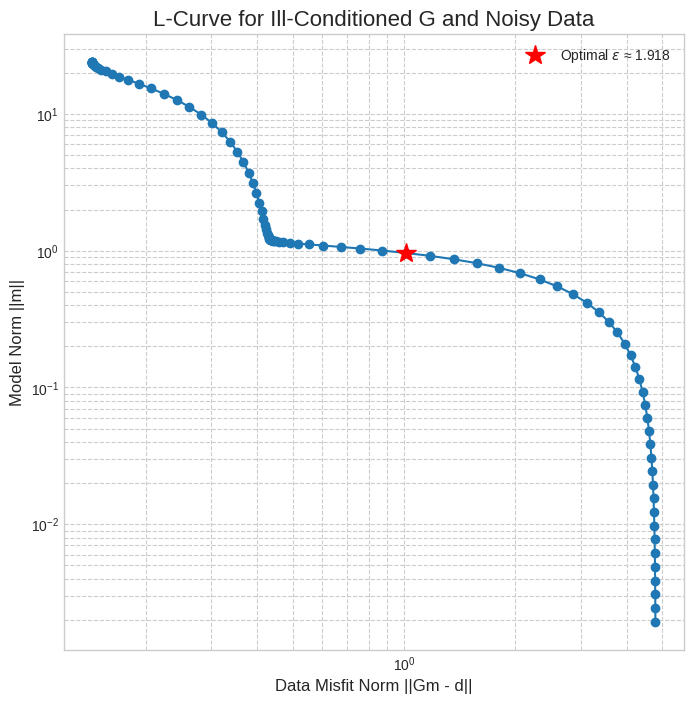

Optimal epsilon for ill-conditioned G AND noisy data: 1.9179


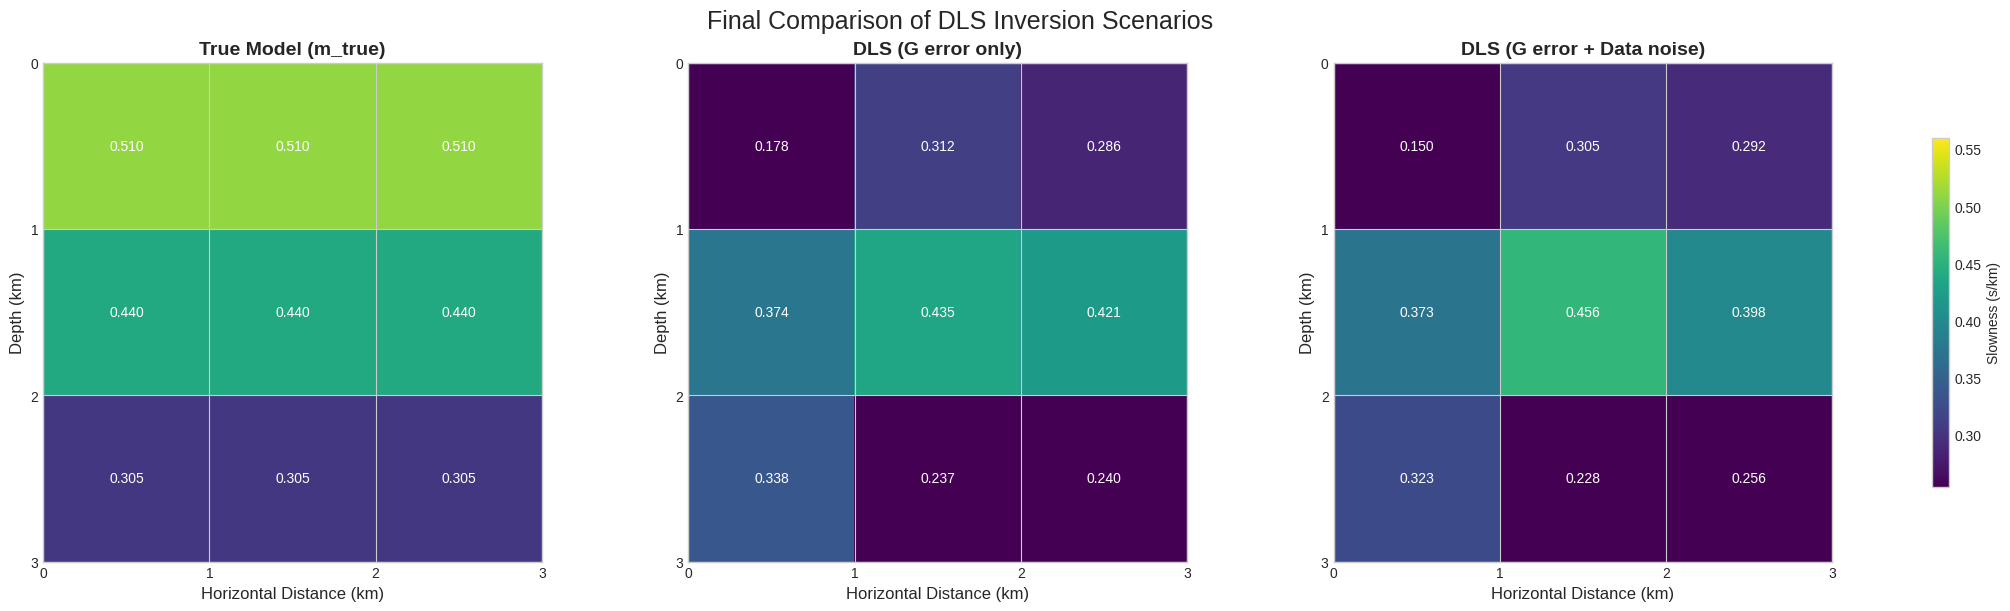

In [ ]:
# --- DLS Inversion on G_noisy with d_noisy ---

# Again, we find the optimal epsilon for this new combined problem.
epsilons = np.logspace(-3, 2, 100) # Adjusted range
data_misfits_combo = []
model_norms_combo = []
I = np.identity(M)

for eps in epsilons:
    # DLS formula using G_noisy and d_noisy
    A = G_noisy.T @ G_noisy + (eps**2) * I
    m_dls = np.linalg.inv(A) @ G_noisy.T @ d_noisy

    data_misfits_combo.append(np.linalg.norm(G_noisy @ m_dls - d_noisy))
    model_norms_combo.append(np.linalg.norm(m_dls))

# --- Plot the L-Curve for this combined problem ---
plt.figure(figsize=(8, 8))
plt.loglog(data_misfits_combo, model_norms_combo, 'o-')
plt.title('L-Curve for Ill-Conditioned G and Noisy Data', fontsize=16)
plt.xlabel('Data Misfit Norm ||Gm - d||', fontsize=12)
plt.ylabel('Model Norm ||m||', fontsize=12)
plt.grid(True, which="both", ls="--")

# Find the optimal epsilon from the L-curve
log_misfits = np.log(data_misfits_combo)
log_norms = np.log(model_norms_combo)
distances = np.sqrt(log_misfits**2 + log_norms**2)
corner_index = np.argmin(distances)
optimal_epsilon_combo = epsilons[corner_index]

plt.plot(data_misfits_combo[corner_index], model_norms_combo[corner_index], 'r*', markersize=15,
         label=rf'Optimal $\epsilon$ ≈ {optimal_epsilon_combo:.3f}')
plt.legend()
plt.show()

print(f"Optimal epsilon for ill-conditioned G AND noisy data: {optimal_epsilon_combo:.4f}")

# --- Perform the final DLS inversion ---
A_optimal_combo = G_noisy.T @ G_noisy + (optimal_epsilon_combo**2) * I
m_dls_combo = np.linalg.inv(A_optimal_combo) @ G_noisy.T @ d_noisy

# --- Visualize all key results for comparison ---
fig, axes = plt.subplots(1, 3, figsize=(21, 6), constrained_layout=True)

im = plot_model(axes[0], m_true, 'True Model (m_true)')
plot_model(axes[1], m_dls_g_err, rf'DLS (G error only)')
plot_model(axes[2], m_dls_combo, rf'DLS (G error + Data noise)')

fig.colorbar(im, ax=axes.ravel().tolist(), label='Slowness (s/km)', shrink=0.7)
plt.suptitle('Final Comparison of DLS Inversion Scenarios', fontsize=18)
plt.show()

In [ ]:
print("\nTrue Slowness Model (m_true):\n", np.round(m_true, 3))

print("\nm (G error only):\n", np.round(m_dls_g_err, 3))

print("\nm (G error + Data noise):\n", np.round(m_dls_combo, 3))


True Slowness Model (m_true):
 [0.51  0.51  0.51  0.44  0.44  0.44  0.305 0.305 0.305]

m (G error only):
 [0.178 0.312 0.286 0.374 0.435 0.421 0.338 0.237 0.24 ]

m (G error + Data noise):
 [0.15  0.305 0.292 0.373 0.456 0.398 0.323 0.228 0.256]


# SUMMARY AND CONCLUSION

This project demonstrated the application of least-squares methods to a tomography problem under various conditions.

1.  **Ordinary Least Squares (OLS)**:
    - This method works perfectly for an overdetermined system with ideal, noise-free data, successfully reconstructing the true model. It serves as an ideal baseline.

2.  **Damped Least Squares (DLS)**:
    - **Scenario A (Ill-Conditioned G)**: When the kernel matrix `G` itself is unstable (high condition number), OLS would produce a highly erroneous model. DLS, by adding a small damping term, successfully stabilizes the inversion and recovers a model that is very close to the true model, even when the underlying physics/geometry is uncertain.
    - **Scenario B (Ill-Conditioned G and Noisy Data)**: In the most realistic case, where both the matrix `G` is unstable and the data `d` is noisy, DLS once again proves its value. It simultaneously handles both sources of error, producing a stable and reasonably accurate model. While the result is slightly less accurate than in Scenario A due to the added data noise, it is far superior to what an undamped inversion would produce.

In conclusion, DLS is an essential tool in geophysical inversion. It provides robustness against both instability in the problem's formulation (ill-conditioned `G`) and imperfections in the measurements (noisy `d`), allowing for meaningful results to be extracted from realistic, imperfect data.